# Multi label classification 

#### This notebook contains the codes that are described in Methodology and Results sections of project report
Numerical values in results and plots might be slightly different than what is demonstrated in the written part. 

In [55]:
# installing nessesary libraries
#!pip install ydata-profiling scikit-learn transformers torch seaborn

In [1]:
import requests, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from ydata_profiling import ProfileReport
import gc
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
# classification
from sklearn.model_selection import StratifiedShuffleSplit
from transformers import BertModel, BertTokenizer, AdamW
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [56]:
# the torch version which is currently compatible with CUDA version on Viper is 1.13.1
print(torch.__version__)

1.13.1.post200


In [57]:
# conversation_dataset is the generated dataset by OpenAI apis
df= pd.read_csv('../data/conversation_dataset.csv')
df.head(2)

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic
0,first participant in conversation is deceiving...,"A: Hey, I have something really important to t...",437,1.0,0.0,NaN,NaN
1,second participant in conversation is deceivin...,"A: Hey Sarah, I heard you recently went on a t...",368,0.0,1.0,NaN,NaN


---
The method below, spilits the conversations into truns, using the '\n\n' delimiter which GPT has used for that, and then adds [CLS] token at the start of each turn

In [61]:
def add_cls_token(conversation):
    token = '[CLS]' # the classification token for BERT
    # split the conversation into turns using line breaks as delimiters
    turns = conversation.split('\n\n')
    turns_with_sep = [turn + token for turn in turns]
    return token + ''.join(turns_with_sep)
 
df['conversation'] = df['conversation'].apply(add_cls_token)

Add an id to conversations, so later when analyzing the results in test set, its easier to check the conversations and find associated category and topic for them

In [62]:
df['id'] = [i for i, j in df.iterrows()]

In [6]:
df

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic,id
0,first participant in conversation is deceiving...,"[CLS]A: Hey, I have something really important...",437,1.0,0.0,NaN,NaN,0
1,second participant in conversation is deceivin...,"[CLS]A: Hey Sarah, I heard you recently went o...",368,0.0,1.0,NaN,NaN,1
2,both participants in conversation are deceivin...,"[CLS]A: Hey, how have you been? It's been a wh...",400,1.0,1.0,NaN,NaN,2
3,none of participants in conversation try to de...,[CLS]A: Hey Sarah! How was your weekend?[CLS]B...,494,0.0,0.0,NaN,NaN,3
4,first participant in conversation is deceiving...,[CLS]A: Hey there! How are you doing today?[CL...,534,1.0,0.0,NaN,NaN,4
...,...,...,...,...,...,...,...,...
195,none of participants in conversation try to de...,[CLS]A: Hey there! I've been trying to perfect...,474,0.0,0.0,NaN,cooking tips or recipes,195
196,first participant in conversation is deceiving...,"[CLS]A: Good morning, thank you for having me ...",542,1.0,0.0,NaN,a job interview,196
197,second participant in conversation is deceivin...,[CLS]A: Good afternoon! Thank you for taking t...,803,0.0,1.0,NaN,a job interview,197
198,both participants in conversation are deceivin...,"[CLS]A: Good morning, and thank you for coming...",549,1.0,1.0,NaN,a job interview,198


In [66]:
df.loc[0]['conversation']

"[CLS]A: Hey, I have something really important to tell you.[CLS]B: Sure, what's up?[CLS]A: You know that job opportunity I told you about last month? Well, I got it![CLS]B: Wow, that's amazing news! Congratulations![CLS]A: Thank you! I knew you'd be happy for me. B:ut here's the thing, the company wants me to relocate to another city for this position.[CLS]B: Oh, really? That's a big change. Are you considering it?[CLS]A: Well, I've been thinking about it, but I'm not entirely sure yet. There are a few things to consider, like the cost of living and leaving my family behind.[CLS]B: Of course, those are valid concerns. B:ut if it's a great opportunity, maybe it's worth taking the risk?[CLS]A: That's true, but I've been doing some research, and it seems like the company has a lot of internal issues. I'm starting to doubt if it's the right move for me.[CLS]B: Oh, really? That's concerning. What kind of issues are you talking about?[CLS]A: Well, I've heard rumors that they have financial 

---
### Preprocessing the combined dataset

ProfileReport helps to have a overal look at data  

In [10]:
#ProfileReport(df)

Removing special HTML characters from the conversations

In [8]:
def text_preprocess(message):
    processed = []   
    for text in message:
        # replaace URLs, if there if any 
        text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' <URL>',text) 
        
        # Remove HTML/XML tags (if any)
        text = re.sub(r'<.*?>', '', text)
        
        #Remove punctuation and symbols (not for now)
        #text = re.sub(r'[^\w\s]', '', text) # this will replace [CLS] tokens as well!
        
        # Remove whitespaces (including new lines and tabs)
        text = text.strip().replace("\n", " ").replace("\r", " ").replace("\t", " ")
        
        processed.append(text)       
    return processed

In [9]:
df['conversation'] = text_preprocess(list(df['conversation']))
df

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic,id
0,first participant in conversation is deceiving...,"[CLS]A: Hey, I have something really important...",437,1.0,0.0,NaN,NaN,0
1,second participant in conversation is deceivin...,"[CLS]A: Hey Sarah, I heard you recently went o...",368,0.0,1.0,NaN,NaN,1
2,both participants in conversation are deceivin...,"[CLS]A: Hey, how have you been? It's been a wh...",400,1.0,1.0,NaN,NaN,2
3,none of participants in conversation try to de...,[CLS]A: Hey Sarah! How was your weekend?[CLS]B...,494,0.0,0.0,NaN,NaN,3
4,first participant in conversation is deceiving...,[CLS]A: Hey there! How are you doing today?[CL...,534,1.0,0.0,NaN,NaN,4
...,...,...,...,...,...,...,...,...
195,none of participants in conversation try to de...,[CLS]A: Hey there! I've been trying to perfect...,474,0.0,0.0,NaN,cooking tips or recipes,195
196,first participant in conversation is deceiving...,"[CLS]A: Good morning, thank you for having me ...",542,1.0,0.0,NaN,a job interview,196
197,second participant in conversation is deceivin...,[CLS]A: Good afternoon! Thank you for taking t...,803,0.0,1.0,NaN,a job interview,197
198,both participants in conversation are deceivin...,"[CLS]A: Good morning, and thank you for coming...",549,1.0,1.0,NaN,a job interview,198


In [10]:
# number of conversation wth more than 512 words (after adding [CLS] token)
long_conversations = sum([1 if len(i.split()) > 512 else 0 for i in df['conversation']])
long_conversations

115

In [11]:
df['conversation'].str.split().apply(lambda x : len(x)).describe()

count     200.000000
mean      549.415000
std       141.961077
min       272.000000
25%       453.000000
50%       532.500000
75%       620.500000
max      1428.000000
Name: conversation, dtype: float64

---
Visualize the number of words in each conversation, very long conversations may cause CUDA out-of-memory issue in training process

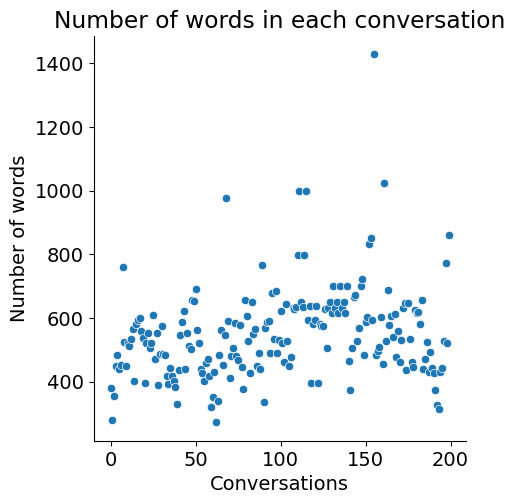

In [71]:
lensofc = [len(i.split()) for i in df['conversation']]
long_c_plot = sns.relplot(lensofc)
long_c_plot.set_ylabels("Number of words", clear_inner=False)
long_c_plot.set_xlabels("Conversations", clear_inner=False)
long_c_plot.set(title = "Number of words in each conversation")

---
### Prepare dataset for classification

Check if dataset is balanced across classes for both labels

<Axes: xlabel='A_bad_intent', ylabel='count'>

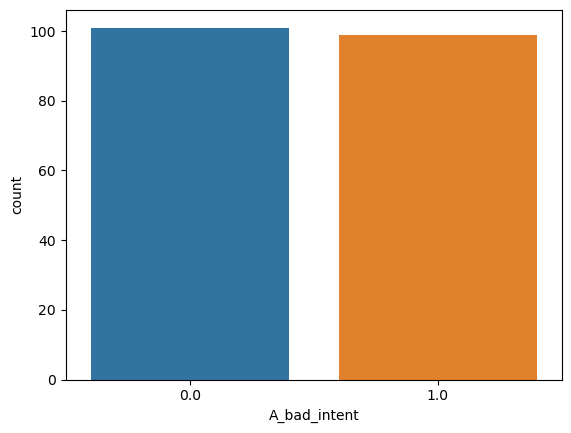

In [16]:
sns.countplot(data = df, x= df['A_bad_intent'])

<Axes: xlabel='B_bad_intent', ylabel='count'>

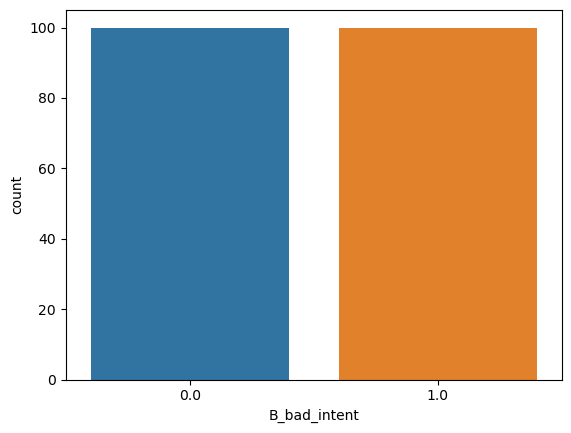

In [17]:
sns.countplot(data = df, x= df['B_bad_intent'])

+ Normalization /scaling --> no need when using BERT
+ Shuffling --> shuffle=True in train_test_split


Spilit dataset into train, test and validation, ensuring a balanced distribution between categories

In [24]:
# reset the index of the df to ensure it's a range index
df = df.reset_index(drop=True)

TRAIN_TEST_SPILIT = 0.28 # to spilit dataset into 3 sets with a balanced distribution of categories
splitter = StratifiedShuffleSplit(n_splits=1, test_size=TRAIN_TEST_SPILIT, random_state=42)   # or test_size=0.32

# split the dataset into training and temp (validation + test) sets
for train_index, temp_index in splitter.split(df, df['category']):
    train_df = df.loc[train_index]
    temp_df = df.loc[temp_index]
    
#reset the index of temp df    
temp_df = temp_df.reset_index(drop=True)

# again, use StratifiedShuffleSplit to split the temp set into validation and test sets (half for test and half for validation)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in splitter.split(temp_df, temp_df['category']):
    val_df = temp_df.loc[val_index]
    test_df = temp_df.loc[test_index]      

#### Are train, validation and test spilits balanced?

<Axes: xlabel='count', ylabel='category'>

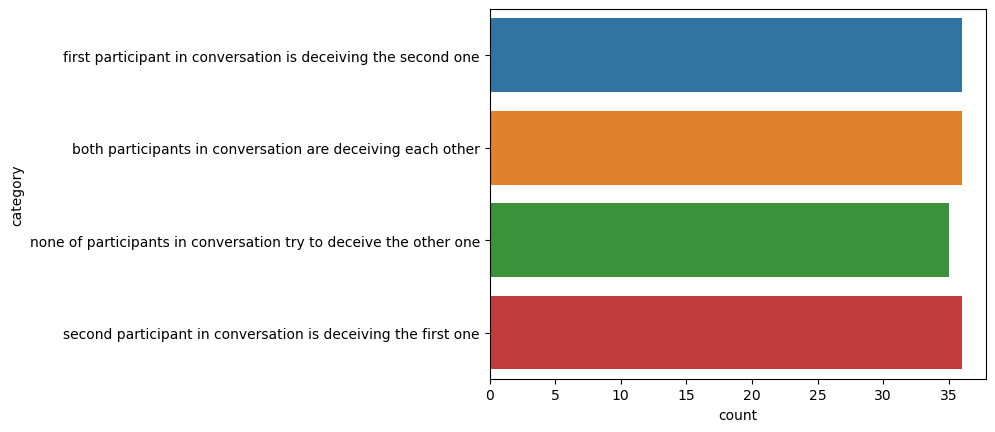

In [25]:
sns.countplot(y = train_df['category'])

<Axes: xlabel='count', ylabel='category'>

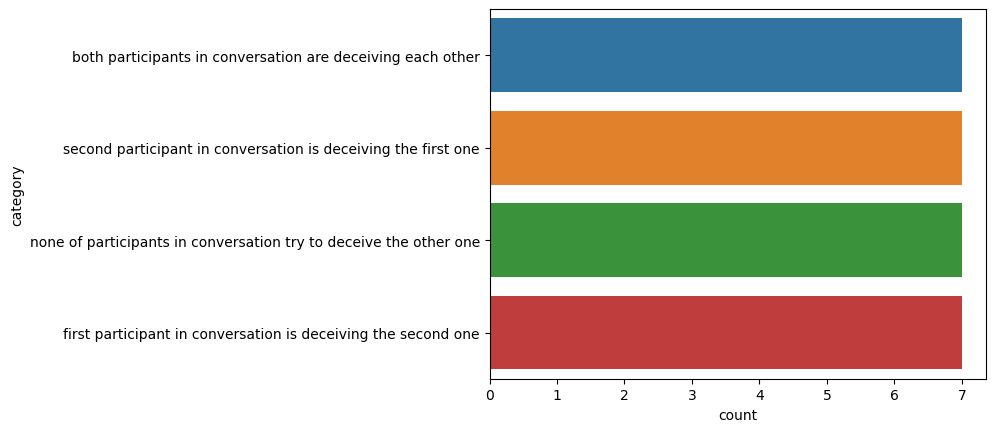

In [26]:
sns.countplot(y = val_df['category'])

<Axes: xlabel='count', ylabel='category'>

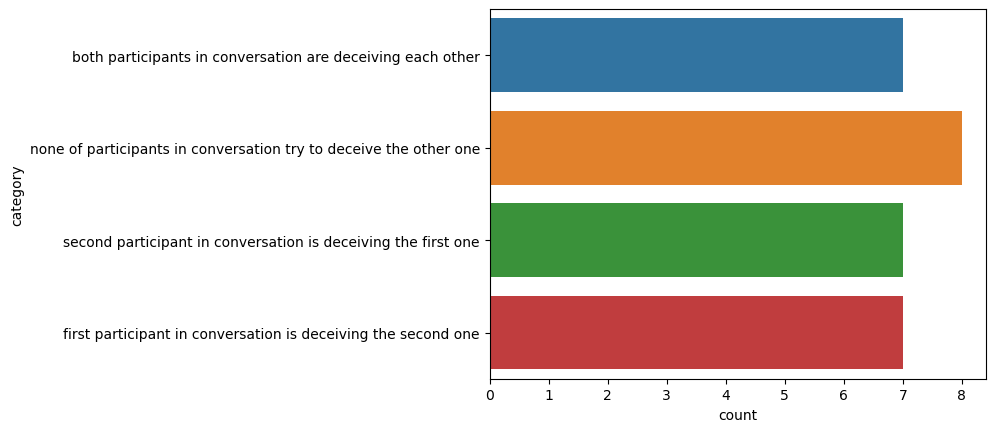

In [27]:
sns.countplot(y = test_df['category'])

---
## Classification

Check the device which is available

In [74]:
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
    print('Number of GPUs available: ' , torch.cuda.device_count())   
else:
    print('using the CPU')
    device = torch.device("cpu")

GPU: NVIDIA A100 80GB PCIe MIG 2g.20gb
Number of GPUs available:  1


---
#### Hyperparamethers 
values are in the suggested range by BERT developers. from the Appendix A.3 of this paper:  https://arxiv.org/pdf/1810.04805.pdf

+ Batch size: 16, 32 (here to make code run on low memory batch size is smaller)
+ Learning rate (Adam): 5e-5, 3e-5, 2e-5
+ Number of epochs: 2, 3, 4

In [75]:
BATCH_SIZE = 8
LEARNING_RATE = 3e-5
EPOCHS = 3
OPTIMIZATION_STEPS = 1 # Optimize model parameters in process of each batch, should be adjust to fit with avaialable memory 

#OVERLAP = 25 # the overlap when chunking conversations, now its hardcoded in the class definition

#to tackle overfitting of the model, L2 regularization and adding a drop out layer were tried but did not help
#what actually helped to fix overfitting was doing optimization in each iteration of batch process
#it was set to be run for every 4 batch where the diplomacy dataset was being used and that was a bigger dataset with very longer conversations
#but OpenAI dataset can handle optimization in each step

#WEIGHT_DECAY = 1e-2 # 1e-2,1e-3 ,1e-4 ,1e-5, 1e-6 # DIDNT HELP
#ROPOUT_RATE = 1 # drop out didnt help


---
### Code Base

---
Classification Model, to label each actor in the conversation

In [20]:
class ParticipantClassifier(nn.Module):
    def __init__(self, bert_model_name):
        super(ParticipantClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        #BERT already comes with dropout in its architecture, but lets add additional dropout layers to the classifier
        #self.dropout = nn.Dropout(ROPOUT_RATE)
        #add a linear layer that maps the hidden state to two outputs, labels
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
 
    # input_ids, attention_mask are ouputs of tokenizer
    def forward(self, input_ids, attention_mask):
        # pass the input to the model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # [CLS] token representation
        #dropout layer
        #pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        # models confidence score for each calss
        logits_a = logits[:, 0]
        logits_b = logits[:, 1]
        return logits_a, logits_b

---
Tokenize and chunck conversations to segments with less than 512 tokens

In [21]:
class ConversationDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512, overlap=25): # overlap hardcoded
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.overlap = overlap
        
    def __len__(self):
        return len(self.data)
    
    def _tokenize(self, text):
        """Tokenize the text into overlapping segments."""
        tokens = self.tokenizer.encode(text, add_special_tokens=False)
        segments = []
        if len(tokens) > self.max_length :  # if the list of tokens is longer than 512 tokens
            start = 0
            while start < len(tokens):
                # to make sute the last segment finish at the end of the token lengh 
                end = min(start + self.max_length, len(tokens))
                segment = tokens[start:end]              
                segments.append(segment)              
                # update the start of the next chunk
                # so the next segment will start from the next - overlap, 
                # means 25 tokens from previous segment are included to new segment as well
                start += self.max_length - self.overlap
       
        else:
            segments.append(tokens)
        return segments
    
    def __getitem__(self, idx):
        text = self.data[idx]['conversation']
        segments = self._tokenize(text)
        # process each segment
        inputs = [self.tokenizer.prepare_for_model(
                    seg,
                    add_special_tokens=False,  # I add special tokens manually
                    max_length=self.max_length,
                    padding='max_length',
                    return_tensors='pt', # pytorch
                    truncation=True # 
                  ) for seg in segments]
        
        label_a = 1 if self.data[idx]['A_bad_intent'] == 1 else 0
        label_b = 1 if self.data[idx]['B_bad_intent'] == 1 else 0
        
        # return a list of segments, each with its own input_ids and attention_mask
        return {
            'segments': [{
                'input_ids': input['input_ids'].squeeze(),
                'attention_mask': input['attention_mask'].squeeze()
            } for input in inputs],
            'A_bad_intent': label_a,
            'B_bad_intent': label_b,
            'id' : self.data[idx]['id']
        }

---

To ensure that each batch processed by the model has the same shape, collate_fn pads the sequences so that all data in a batch have the same length


In [22]:
def collate_fn(batch):
    """
    Custom collate function for handling batches of segmented conversations.
    """
    # lists to store the sequences and labels for all segments across all batch items
    input_ids_list = []
    attention_mask_list = []
    labels_a_list = []
    labels_b_list = []
    ids  = []
    # list to store the segments for all batch items
    batch_segments = []
 
    for item in batch:
        # accumulate the labels for each item in the batch
        labels_a_list.append(item['A_bad_intent'])
        labels_b_list.append(item['B_bad_intent'])
        ids.append(item['id'])
        # collect segments from each item in the batch
        item_segments = []
        for segment in item['segments']:
            # for each segment, extract input_ids and attention_mask
            input_ids = segment['input_ids']
            attention_mask = segment['attention_mask']
 
            # append the segment's input_ids and attention_mask to the respective lists
            input_ids_list.append(input_ids)
            attention_mask_list.append(attention_mask)
 
            # also collect segments for this item
            item_segments.append({
                'input_ids': input_ids,
                'attention_mask': attention_mask
            })
 
        batch_segments.append(item_segments)
 
    # pad the sequences so that each sequence in the batch has the same length
    input_ids_padded = pad_sequence(input_ids_list, batch_first=True, padding_value=0)
    attention_mask_padded = pad_sequence(attention_mask_list, batch_first=True, padding_value=0)
    # convert labels lists to torch tensors
    labels_a = torch.tensor(labels_a_list)
    labels_b = torch.tensor(labels_b_list)
 
    # return the dictionary with padded 'input_ids', 'attention_mask' and 'segments'
    return {
        'segments': batch_segments,
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'A_bad_intent': labels_a,
        'B_bad_intent': labels_b,
        'id' : ids
    }

remove variables after use and collect the garbage to manage memory usage more efficiently

In [35]:
# this methods deletes two vriables(becsouse in processing dataloader input and output varaibles are double) and collect garbage
def gc_colloctor(a, b) : 
    del a
    del b
    gc.collect()

from https://www.kaggle.com/code/jaskaransingh/bert-fine-tuning-with-pytorch
    
Training:

+ Unpack our data inputs and labels
+ Load data onto the GPU for acceleration
+ Clear out the gradients calculated in the previous pass.
+ In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
+ Forward pass (feed input data through the network)
+ Backward pass (backpropagation)
+ Tell the network to update parameters with optimizer.step()
+ Track variables for monitoring progress

Evalution:

+ Unpack our data inputs and labels
+ Load data onto the GPU for acceleration
+ Forward pass (feed input data through the network)
+ Compute loss on our validation data and track variables for monitoring progress

In [37]:
# train and validation have a very similar proceess, lets put that in a function
def process_dataloader(model, dataloader, device, step, accumulation_steps = 1):
    num_batch = 0
    
    total_loss_a = 0
    total_loss_b = 0   
    true_labels_a = []
    true_labels_b = []
    pred_labels_a = []
    pred_labels_b = []
    
    for i, batch in enumerate(dataloader):
        torch.cuda.empty_cache()
        num_batch += 1
        print(num_batch , ' batch ...')
        #optimizer.zero_grad()  # zero the parameter gradients at the end of loop    
        
        # labels need to be of float type and reshaped to be of the same size as output logits
        labels_a = batch['A_bad_intent'].to(device).float()
        labels_b = batch['B_bad_intent'].to(device).float()
        # initialize variables to accumulate the logits for all segments
        logits_a_accumulated = []
        logits_b_accumulated = []
      
       # print('len of sengmentS' , len(batch['segments']))
        for segments in batch['segments']:  # now 'segments' is a list of dictionaries   
            torch.cuda.empty_cache()
            logits_a_list = []
            logits_b_list = []
            
            #print('len of sengment..' , len(segments))
            for segment in segments:
                # to empty cuda catch and handl memory usgae
                torch.cuda.empty_cache()
                # segment is a dictionary as expected
                input_ids = segment['input_ids'].to(device)
                attention_mask = segment['attention_mask'].to(device)           
                #print(f"Input IDs shape: {segment['input_ids'].shape}")
                #print(f"Attention Mask shape: {segment['attention_mask'].shape}")
                
                # clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically  
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                model.zero_grad()
                
                # forward pass for this segment
                logits_a, logits_b = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
                gc_colloctor(input_ids, attention_mask )
                #print('Model output:', logits_a, logits_b)
                
                logits_a_list.append(logits_a)
                logits_b_list.append(logits_b)
                gc_colloctor(logits_a, logits_b )
                            
            # aggregate the results for all segments of this item
            # use the mean of the logits
            logits_a_item = torch.mean(torch.stack(logits_a_list), dim=0)
            logits_b_item = torch.mean(torch.stack(logits_b_list), dim=0)
            
            # accumulate the logits for all items
            logits_a_accumulated.append(logits_a_item)
            logits_b_accumulated.append(logits_b_item)
            gc_colloctor(logits_a_item, logits_b_item )
            
        # combine the accumulated logits for the whole batch
        logits_a = torch.cat(logits_a_accumulated, dim=0)
        logits_b = torch.cat(logits_b_accumulated, dim=0)
        #gc_colloctor(logits_b_accumulated, logits_a_accumulated )

        # compute loss for both outputs
        loss_a = loss_function(logits_a, labels_a)
        loss_b = loss_function(logits_b, labels_b)
        
        # convert logits to probabilities and then to binary predictions
        probs_a = torch.sigmoid(torch.cat(logits_a_accumulated)).cpu().detach().numpy()
        probs_b = torch.sigmoid(torch.cat(logits_b_accumulated)).cpu().detach().numpy()
        
        gc_colloctor(logits_a_list, logits_b_list )
        
        preds_a = (probs_a > 0.5).astype(int)
        preds_b = (probs_b > 0.5).astype(int)

        # collect the true labels and predictions
        true_labels_a.extend(batch['A_bad_intent'].numpy())
        true_labels_b.extend(batch['B_bad_intent'].numpy())
        pred_labels_a.extend(preds_a)
        pred_labels_b.extend(preds_b)
        # accumulate the loss
        total_loss_a += loss_a.item()
        total_loss_b += loss_b.item()
        gc_colloctor(logits_a, logits_b )
        
        loss = (loss_a + loss_b) / 2  # combine the losses 
        gc_colloctor(loss_a, loss_b )      
        
        # clip the norm of the gradients to 1.0.
        # this is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        if (step == 'train'):
            loss = loss / accumulation_steps  # normalize the loss
            # backward pass and optimize
            loss.backward()      
            #optimizer.step()
            #perform optimization every 'accumulation_steps' iterations
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad() 
                       
     
    # calculate average loss and accuracy for the epoch
    avg_loss_a = total_loss_a / len(dataloader)
    avg_loss_b = total_loss_b / len(dataloader)
    accuracy_a = accuracy_score(true_labels_a, pred_labels_a)
    accuracy_b = accuracy_score(true_labels_b, pred_labels_b)
    
    return avg_loss_a, avg_loss_b, accuracy_a, accuracy_b

This function will be performed on the test set of data, so no need to back propogation and computing Loss, 
this method will return true and predicted values for labels to later calculate acuuracy, f1 score and other metrics.

In [36]:
def compute_metrics(model, dataloader, device):
    model.eval()  # put model in evaluation mode
    true_labels_a = []
    true_labels_b = []
    pred_labels_a = []
    pred_labels_b = []
    ids = []
 
    with torch.no_grad():  # no need to track gradients for evaluation
        for batch in dataloader:
            # initialize lists to store logits for all segments
            logits_a_list = []
            logits_b_list = []
            # aggregate logits for each segment in the batch
            for segments in batch['segments']:  # 'segments' is a list of dictionaries
                segment_logits_a = []
                segment_logits_b = []
                for segment in segments:
                    input_ids = segment['input_ids'].to(device)
                    attention_mask = segment['attention_mask'].to(device)
                    logits_a, logits_b = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
                    gc_colloctor(input_ids, attention_mask )
                    
                    segment_logits_a.append(logits_a)
                    segment_logits_b.append(logits_b)
                    gc_colloctor(logits_a, logits_b)
                    
                # combine the logits from all segments for the current example
                logits_a = torch.mean(torch.stack(segment_logits_a), dim=0)
                logits_b = torch.mean(torch.stack(segment_logits_b), dim=0)
                gc_colloctor(segment_logits_a, segment_logits_b)
                
                logits_a_list.append(logits_a)
                logits_b_list.append(logits_b)
                gc_colloctor(logits_a, logits_b)
 
            # convert logits to probabilities 
            probs_a = torch.sigmoid(torch.cat(logits_a_list)).cpu().numpy()
            probs_b = torch.sigmoid(torch.cat(logits_b_list)).cpu().numpy()
            # convert probabilities to binary values based on a 0.5 threshold
            preds_a = (probs_a > 0.5).astype(int)
            preds_b = (probs_b > 0.5).astype(int)
 
            # collect the true labels and predictions
            true_labels_a.extend(batch['A_bad_intent'].numpy())
            true_labels_b.extend(batch['B_bad_intent'].numpy())
            pred_labels_a.extend(preds_a)
            pred_labels_b.extend(preds_b)
            ids.extend(batch['id'])
 
 
   
    return {'True_A' : true_labels_a,
            'Predicted_A' : pred_labels_a,
            'True_B' : true_labels_b,
            'Predicted_B' : pred_labels_b,
            'ids' : ids
        
    }
    

Training and evaluation functions, the main diffreence is the model mode and tracking gradients,  
each function returns loss and accuracy for labels during its procedure

In [38]:
def train_model(model, dataloader, device):
    accumulation_steps = OPTIMIZATION_STEPS  
    model.train()  # set the model to training mode
    avg_loss_a, avg_loss_b, accuracy_a, accuracy_b = process_dataloader(model, dataloader, device,'train', accumulation_steps)  
    return  avg_loss_a, avg_loss_b, accuracy_a, accuracy_b

In [39]:
def evaluate_model(model, dataloader, device):
    model.eval()  # put model in evaluation mode, the dropout layers behave differently
 
    with torch.no_grad():  # no need to track gradients for evaluation
        avg_loss_a, avg_loss_b, accuracy_a, accuracy_b = process_dataloader(model, dataloader, device,'val') 
        
    return avg_loss_a, avg_loss_b, accuracy_a, accuracy_b

---
### Create the objects and utialize them

---
To feed the text to BERT, first it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

In [23]:
#bert-base-uncased model has only lowercase letters!
#bert-base-cased: This model is case-sensitive: it makes a difference between english and English.
tokenizer = BertTokenizer.from_pretrained('bert-base-cased') # , do_lower_case=False 

Turn dataframes into dictionaries for ConversationDataset input

In [28]:
train_data = train_df.to_dict('records')
val_data = val_df.to_dict('records')
test_data = test_df.to_dict('records')

Create batchs and suffle the data for all sets of train, validation and test

In [30]:
# ConversationDataset will tokenize the conversations and chunk them into spilits to handle 512 limit
train_dataset = ConversationDataset(train_data, tokenizer, max_length=512)
# feed input_isd and attention_masks + labels to Dataloader to create batch of data and shuffle 
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True ,collate_fn=collate_fn)

val_dataset = ConversationDataset(val_data, tokenizer, max_length=512)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

test_dataset = ConversationDataset(test_data, tokenizer, max_length=512)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

Model & Optimizer

In [40]:
# ParticipantClassifier is the speaker classifier model, which basically employs BERt model
model = ParticipantClassifier('bert-base-cased')
# , eps=1e-8 eps: a very small number to prevent any division by zero --> removed
# , weight_decay = WEIGHT_DECAY --> did not help
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE) 
# Binary Cross-Entropy with Logits Loss
loss_function = nn.BCEWithLogitsLoss()

Load th model into GPU

In [41]:
model = model.to(device)

---
### Inspecting some  elements

In [29]:
# Print the original conversation for a sample conversation
print(' Original: ', train_data[30])
# Print that split into tokens.
tokenized_sample = tokenizer.tokenize(train_data[30]['conversation'])
print('Tokenized: ', tokenized_sample)
# Print mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenized_sample))

 Original:  {'category': 'second participant in conversation is deceiving the first one', 'conversation': "[CLS]A: Hey! I'm trying to make a lasagna for the first time. Could you give me some tips on how to get it perfect?[CLS]B: Of course! First thing is you don't actually need to boil the lasagna noodles. Just layer them in dry; they'll cook in the sauce.[CLS]A: Really? I always thought you had to boil them first. That saves time. What about the sauce?[CLS]B: Well, a little trick I like to use is to add a cup of ketchup to the tomato sauce. It gives it a unique tanginess that's just delicious.[CLS]A: Ketchup, huh? That's new to me. What about the cheese? Any recommendations?[CLS]B: You should definitely use Swiss cheese. It melts better than mozzarella and gives a really sophisticated taste to the dish.[CLS]A: Interesting choice, Swiss cheese. I'll give it a try. And the meat?[CLS]B: Instead of ground beef, go for some chopped hot dogs. They are pre-cooked, so it saves you a step, an

In [31]:
# check dtaset output
train_dataset[30]

{'segments': [{'input_ids': tensor([  101,   138,   131,  4403,   106,   146,   112,   182,  1774,  1106,
            1294,   170, 17496,  8517,  1605,  1111,  1103,  1148,  1159,   119,
            7426,  1128,  1660,  1143,  1199, 10538,  1113,  1293,  1106,  1243,
            1122,  3264,   136,   101,   139,   131,  2096,  1736,   106,  1752,
            1645,  1110,  1128,  1274,   112,   189,  2140,  1444,  1106,   171,
           20708,  1103, 17496,  8517,  1605,  1185, 27267,   119,  2066,  6440,
            1172,  1107,  3712,   132,  1152,   112,  1325,  9834,  1107,  1103,
           14313,   119,   101,   138,   131,  8762,   136,   146,  1579,  1354,
            1128,  1125,  1106,   171, 20708,  1172,  1148,   119,  1337, 14419,
            1159,   119,  1327,  1164,  1103, 14313,   136,   101,   139,   131,
            2119,   117,   170,  1376,  7959,   146,  1176,  1106,  1329,  1110,
            1106,  5194,   170,  4355,  1104,   180,  2105, 17143,  1643,  1106,
   

In [32]:
# test chunking tokens for a sample conversation:
tokens = tokenizer.encode(train_data[30]['conversation'], add_special_tokens=False)
segments = []
print('len of tokens', len(tokens))
if len(tokens) > 512:  
    start = 0
    while start < len(tokens):
        end = min(start + 510, len(tokens))
        print('end' , end)
        segment = tokens[start:end]
        segments.append(segment)              
        start += 512 - 50 # here overlap is 50
        print('start' , start)

else:
    segments.append(tokens)
print(segments)

len of tokens 490
[[101, 138, 131, 4403, 106, 146, 112, 182, 1774, 1106, 1294, 170, 17496, 8517, 1605, 1111, 1103, 1148, 1159, 119, 7426, 1128, 1660, 1143, 1199, 10538, 1113, 1293, 1106, 1243, 1122, 3264, 136, 101, 139, 131, 2096, 1736, 106, 1752, 1645, 1110, 1128, 1274, 112, 189, 2140, 1444, 1106, 171, 20708, 1103, 17496, 8517, 1605, 1185, 27267, 119, 2066, 6440, 1172, 1107, 3712, 132, 1152, 112, 1325, 9834, 1107, 1103, 14313, 119, 101, 138, 131, 8762, 136, 146, 1579, 1354, 1128, 1125, 1106, 171, 20708, 1172, 1148, 119, 1337, 14419, 1159, 119, 1327, 1164, 1103, 14313, 136, 101, 139, 131, 2119, 117, 170, 1376, 7959, 146, 1176, 1106, 1329, 1110, 1106, 5194, 170, 4355, 1104, 180, 2105, 17143, 1643, 1106, 1103, 26422, 14313, 119, 1135, 3114, 1122, 170, 3527, 15925, 10533, 5800, 1115, 112, 188, 1198, 13108, 119, 101, 138, 131, 26835, 6943, 4455, 117, 11159, 136, 1337, 112, 188, 1207, 1106, 1143, 119, 1327, 1164, 1103, 9553, 136, 6291, 11859, 136, 101, 139, 131, 1192, 1431, 5397, 1329, 4614

In [33]:
len(segments)

1

In [34]:
# len of all tokens after chunking, considering the overlap
all_len = 0
for i in segments:
    all_len += len(i)
print(all_len)

490


In [35]:
# sometime there is indices error when training, lets check if :
#Token indices sequence length is longer than the specified maximum sequence length for this model
for i, j in enumerate(train_dataset):
    for a, b in enumerate(train_dataset[i]['segments']):
        if len(train_dataset[i]['segments'][a]['input_ids']) > 512:
            print('in train dataset:')
            print(i,a, len(train_dataset[i]['segments'][a]['input_ids']))
        
for i, j in enumerate(val_dataset):
    for a, b in enumerate(val_dataset[i]['segments']):
        if len(val_dataset[i]['segments'][a]['input_ids']) > 512:
            print('in val dataset:')
            print(i, len(val_dataset[i]['segments'][a]['input_ids']))
        
for i, j in enumerate(test_dataset):
    for a, b in enumerate(test_dataset[i]['segments']):
        if len(test_dataset[i]['segments'][a]['input_ids']) > 512:
            print('in test dataset:')
            print(i, len(test_dataset[i]['segments'][a]['input_ids']))

In [42]:
device

device(type='cuda')

In [43]:
train_dataloader.batch_size

8

In [44]:
# printing model's parameters
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n First Transformer ====\n')
for p in params[5:21]:    
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n Output Layer ====\n')
for p in params[-4:]:    
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

 First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
ber

In [51]:
#@todo check oov words

---
### Training

In [53]:
#gives a readable summary of memory allocation and allows to figure the reason of CUDA running out of memory
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [45]:
epochs = EPOCHS 
test_metrics = []

validation_loss_a = []
validation_loss_b = []
validation_accuracy_a = []
validation_accuracy_b = []

train_loss_a = []
train_loss_b = []
training_accuracy_a = []
training_accuracy_b = []

for epoch in range(epochs):  
    
    print('epoch === ', epoch)
    
    print('Training ***')
    avg_train_loss_a, avg_train_loss_b, train_accuracy_a, train_accuracy_b = train_model(model, train_dataloader, device)
    print(f'Training Loss after epoch {epoch}: A : {avg_train_loss_a} B: {avg_train_loss_b}')
    print(f'Training Accuracy after epoch {epoch}: A : {train_accuracy_a} B: {train_accuracy_b}')
    train_loss_a.append(avg_train_loss_a)
    train_loss_b.append(avg_train_loss_b)
    training_accuracy_a.append(train_accuracy_a)
    training_accuracy_b.append(train_accuracy_b)
    
    print('Validation ***')
    avg_val_loss_a, avg_val_loss_b, val_accuracy_a, val_accuracy_b = evaluate_model(model, val_dataloader, device)
    print(f'Validation Loss after epoch {epoch}: A : {avg_val_loss_a} B: {avg_val_loss_b}')
    print(f'Validation Accuracy after epoch {epoch}: A : {val_accuracy_a} B: {val_accuracy_b}')
    validation_loss_a.append(avg_val_loss_a)
    validation_loss_b.append(avg_val_loss_b)
    validation_accuracy_a.append(val_accuracy_a)
    validation_accuracy_b.append(val_accuracy_b)

Token indices sequence length is longer than the specified maximum sequence length for this model (841 > 512). Running this sequence through the model will result in indexing errors


epoch ===  0
Training ***
1  batch ...
2  batch ...
3  batch ...
4  batch ...
5  batch ...
6  batch ...
7  batch ...
8  batch ...
9  batch ...
10  batch ...
11  batch ...
12  batch ...
13  batch ...
14  batch ...
15  batch ...
16  batch ...
17  batch ...
18  batch ...
Training Loss after epoch 0: A : 0.6984421412150065 B: 0.7216014398468865
Training Accuracy after epoch 0: A : 0.4755244755244755 B: 0.45454545454545453
Validation ***
1  batch ...
2  batch ...
3  batch ...
4  batch ...
Validation Loss after epoch 0: A : 0.6831981390714645 B: 0.6999407112598419
Validation Accuracy after epoch 0: A : 0.5 B: 0.5
epoch ===  1
Training ***
1  batch ...
2  batch ...
3  batch ...
4  batch ...
5  batch ...
6  batch ...
7  batch ...
8  batch ...
9  batch ...
10  batch ...
11  batch ...
12  batch ...
13  batch ...
14  batch ...
15  batch ...
16  batch ...
17  batch ...
18  batch ...
Training Loss after epoch 1: A : 0.6973161068227556 B: 0.6931344072024027
Training Accuracy after epoch 1: A : 0.531

In [ ]:
#gives a readable summary of memory allocation and allows to figure the reason of CUDA running out of memory
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

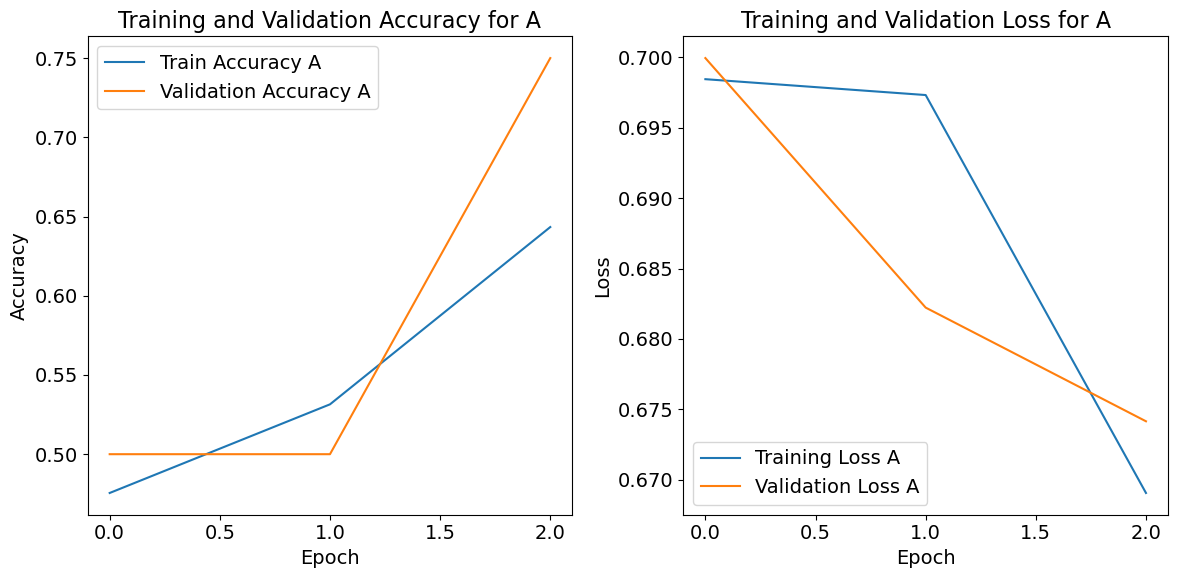

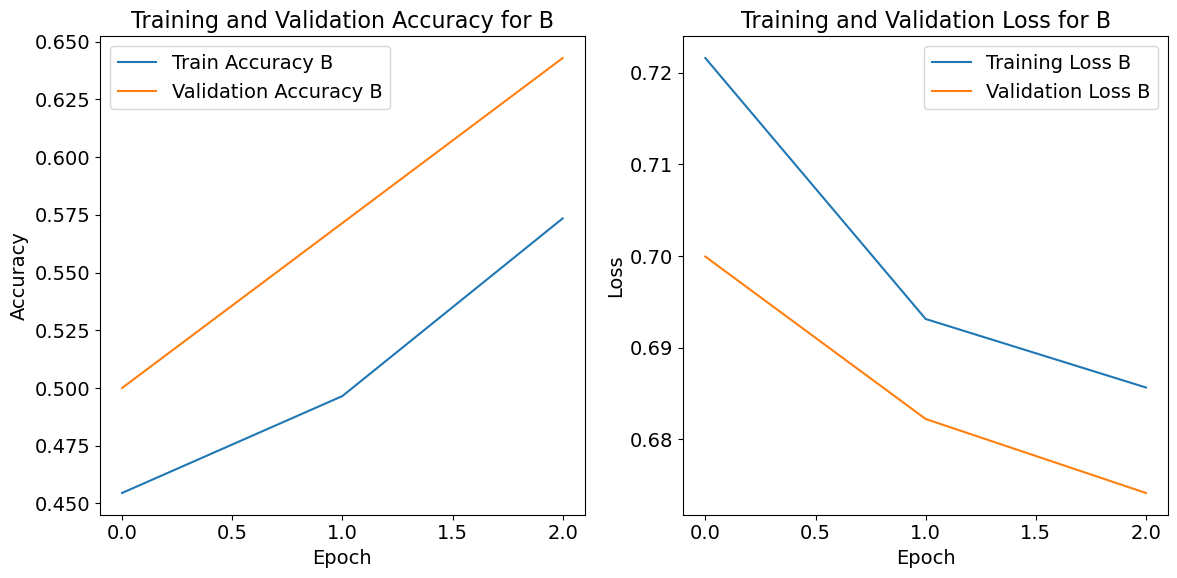

In [46]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), training_accuracy_a, label='Train Accuracy A')
plt.plot(range(epochs), validation_accuracy_a, label='Validation Accuracy A')
plt.xlabel('Epoch', fontsize=14)  
plt.ylabel('Accuracy', fontsize=14)
plt.title(f'Training and Validation Accuracy for A', fontsize=16)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_a, label='Training Loss A')
plt.plot(range(epochs), validation_loss_b, label='Validation Loss A')
plt.xlabel('Epoch', fontsize=14)  
plt.ylabel('Loss', fontsize=14)
plt.title(f'Training and Validation Loss for A', fontsize=16)
plt.legend(fontsize=14)

plt.tight_layout()

# Save the plot as an image
plt.savefig('accuracy_and_loss_plot_A.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

#############
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), training_accuracy_b, label='Train Accuracy B')
plt.plot(range(epochs), validation_accuracy_b, label='Validation Accuracy B')
plt.xlabel('Epoch', fontsize=14)  
plt.ylabel('Accuracy', fontsize=14)
plt.title(f'Training and Validation Accuracy for B', fontsize=16)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_b, label='Training Loss B')
plt.plot(range(epochs), validation_loss_b, label='Validation Loss B')
plt.xlabel('Epoch', fontsize=14)  
plt.ylabel('Loss', fontsize=14)
plt.title(f'Training and Validation Loss for B', fontsize=16)
plt.legend(fontsize=14)

plt.tight_layout()

# Save the plot as an image
plt.savefig('accuracy_and_loss_plot_B.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

sharp changes in  the validation metrics:

+ small validation set -- no (tried to increase the validation set size by ignoring test set and merging that to validation set, but did not help)
+ small batch size -- no (incresing batch size to 16, runing on 28 core CPU, and adjusting other hypertparamethers, maily increasing learning rate, did not help -> the results were almost the same)
+ big learning rate -- no (decresing learning did not help)
+ noise in data

---
### Test and Analysing

In [47]:
print('Test ***')
test_metrics = compute_metrics(model, test_dataloader, device)
print(test_metrics)

Test ***
{'True_A': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0], 'Predicted_A': [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0], 'True_B': [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0], 'Predicted_B': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0], 'ids': [196, 111, 165, 76, 153, 36, 77, 45, 113, 195, 166, 15, 74, 90, 141, 4, 109, 39, 12, 154, 67, 136, 14, 43, 191, 25, 163, 158, 135]}


In [48]:
# compute sklearn metrics here 
test_results = {   
    'accuracy_a': accuracy_score(test_metrics['True_A'], test_metrics['Predicted_A']),
    'accuracy_b': accuracy_score(test_metrics['True_B'], test_metrics['Predicted_B']),
    'f1_a' : f1_score(test_metrics['True_A'], test_metrics['Predicted_A']),
    'f1_b' : f1_score(test_metrics['True_B'], test_metrics['Predicted_B']),
    'precision_a' : precision_score(test_metrics['True_A'], test_metrics['Predicted_A']),
    'precision_b' : precision_score(test_metrics['True_B'], test_metrics['Predicted_B']),
    'recall_a' : recall_score(test_metrics['True_A'], test_metrics['Predicted_A']),
    'recall_b' : recall_score(test_metrics['True_B'], test_metrics['Predicted_B']),
 }
# visualize as a dataframe
test_df = pd.DataFrame.from_dict(test_results, orient='index' ,columns=['Result'])
test_df

,Result
accuracy_a,0.724138
accuracy_b,0.517241
f1_a,0.777778
f1_b,0.650000
precision_a,0.636364
precision_b,0.500000
recall_a,1.000000
recall_b,0.928571


In [49]:
# check some correct and incorrect predictions:
analyzer = {}
for i, c_id  in enumerate(test_metrics['ids']):
    c_id = str(c_id)
    analyzer.update({c_id: {}})
    if(test_metrics['True_A'][i] == test_metrics['Predicted_A'][i]):
          analyzer[c_id]['A'] = 'Correct'
    else:
        analyzer[c_id]['A'] = 'Incorrect'
    if(test_metrics['True_B'][i] == test_metrics['Predicted_B'][i]):
         analyzer[c_id]['B'] = 'Correct'
    else: 
         analyzer[c_id]['B'] = 'Incorrect'

In [50]:
#A dataframe of correct and incorrect predictions on the test set + their category and topic 
analyzer_df = pd.DataFrame.from_dict(analyzer, orient='index')

In [51]:
for i, j in analyzer_df.iterrows():
    analyzer_df.loc[i, 'category'] = df[df['id'] == int(i)]['category'].values[0]
    analyzer_df.loc[i, 'topic'] = df[df['id'] == int(i)]['topic'].values[0]

In [52]:
analyzer_df.head(2)

,A,B,category,topic
196,Correct,Incorrect,first participant in conversation is deceiving...,a job interview
111,Correct,Correct,none of participants in conversation try to de...,a job interview


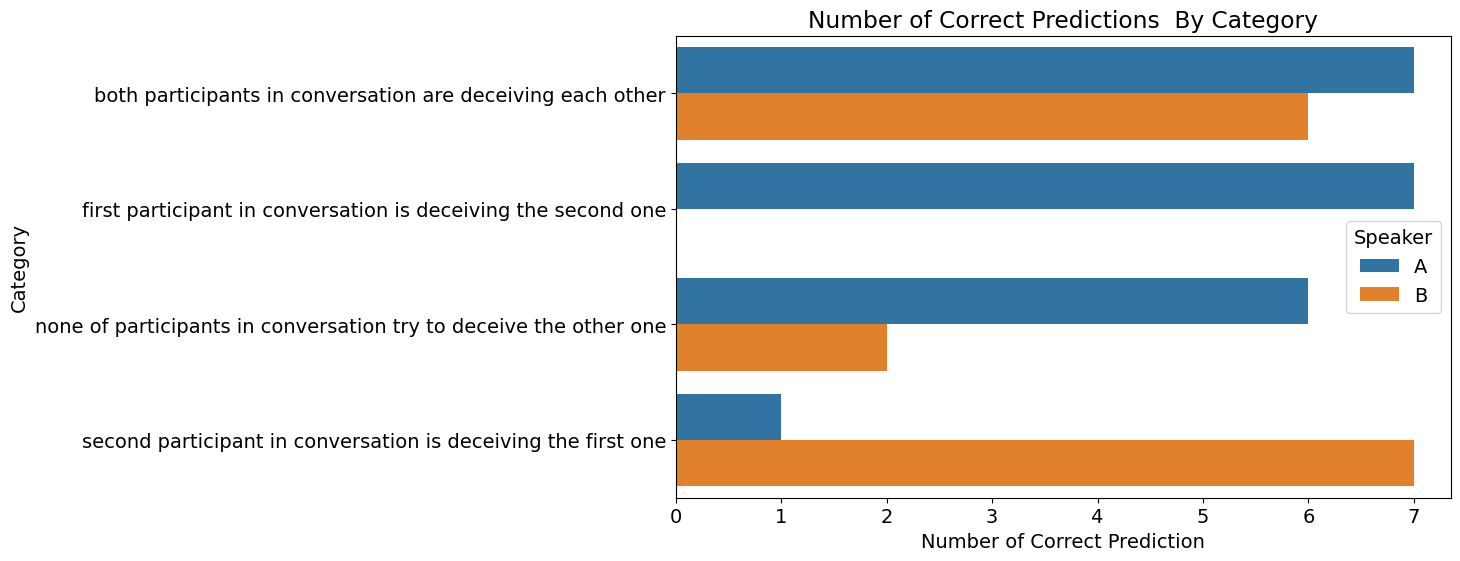

In [53]:
# counting the number of 'Correct' values in A and B for each category
correct_counts = analyzer_df.groupby('category').apply(lambda x: pd.Series({
    'A': (x['A'] == 'Correct').sum(),
    'B': (x['B'] == 'Correct').sum()
})).reset_index()
 
# reshaping the DataFrame for plotting
melted_data = correct_counts.melt(id_vars='category', var_name='Speaker', value_name='Correct_Count')
 
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_data, y='category', x='Correct_Count', hue='Speaker')
plt.title('Number of Correct Predictions  By Category')
plt.ylabel('Category')
plt.xlabel('Number of Correct Prediction')
plt.savefig('./correct_predictions_category.png', dpi=300, bbox_inches='tight')
plt.show()

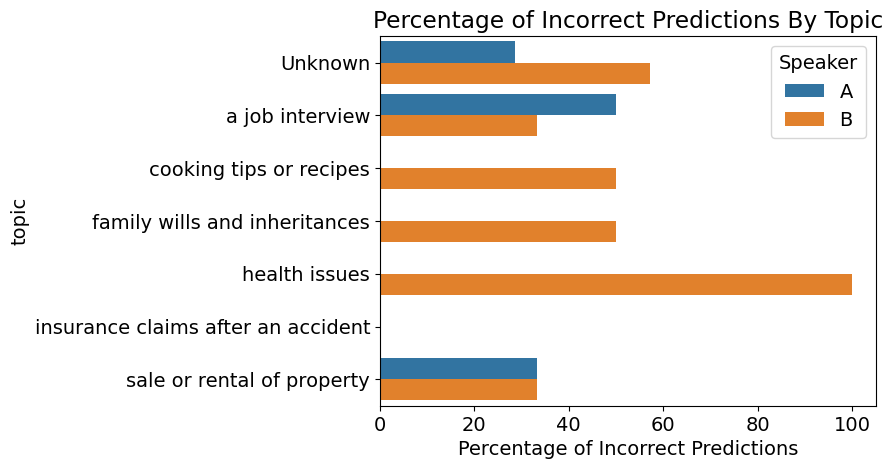

In [54]:
analyzer_df['topic'].fillna('Unknown', inplace=True) # some conversaions don't have topic
# use percentage becouse data was not balanced across topics!
# calculate the percentage of 'Correct' for each topic in both labels
percentage_correct = analyzer_df.groupby('topic').apply(lambda x: pd.Series({
    'A': (x['A'] == 'Incorrect').mean() * 100,
    'B': (x['B'] == 'Incorrect').mean() * 100
})).reset_index()

percentage_correct = percentage_correct.melt(id_vars='topic', var_name='Speaker', value_name='Incorrect_Count')
sns.barplot(data=percentage_correct, y='topic', x='Incorrect_Count', hue='Speaker')
plt.xlabel('Percentage of Incorrect Predictions')
plt.title('Percentage of Incorrect Predictions By Topic')
plt.savefig('./incorrect_predictions_topic.png', dpi=300, bbox_inches='tight')
plt.show()

---
### To do list:

1. Improve chunking tokens --> chunck tokens bsed on each turn in the conversation and include prevouse and later turns for each chunck
2. Improve model performance 
3. Try to add human-like names for speakers, by first creating a list of random names
4. Learning rate scheduler
5. Develop the model for conversation with more than 2 participants
